# Tabular GAN to make minor attack traffics

### Reference
[GAN-for-tabular-data](https://github.com/Diyago/GAN-for-tabular-data)

In [1]:
from tabgan.sampler import OriginalGenerator, GANGenerator, ForestDiffusionGenerator
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

/opt/homebrew/lib/python3.11/site-packages/_ctgan/synthesizer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
attacks = ['DDoS', 'DoS', 'Mirai', 'Recon']

In [3]:
def mergeAttacks(dataframe, attacks):
    """ Merge attacks into big category

    Args:
        dataframe(Pandas dataframe): Contains specific attacks

    Return:
        (Pandas dataframe): merged dataframe
    """

    dataframe.loc[dataframe['label'].str.contains('DDoS'), 'label'] = 'andrew-nah'

    for attack in attacks:
        if attack == 'DDoS':
            continue
        dataframe.loc[dataframe['label'].str.contains(attack), 'label'] = attack
    
    dataframe.loc[dataframe['label'].str.contains('andrew-nah'), 'label'] = 'DDoS'
    
    return dataframe

In [4]:
def dropMajor(dataframe):
    """ Drop the designated attacks

    Args:
        data(Pandas dataframe): data without labels
        label(Pandas dataframe): corresponding labels to data

    Return:
        (Pandas dataframe): dataframe without designated attacks

    """
    df_filtered = dataframe.drop(dataframe[dataframe['label'].isin(['DDoS', 'DoS', 'Mirai'])].index)
    return df_filtered


In [5]:
path_train_data = './data/2_rf_test_unknown_data.csv'
path_train_label = './data/2_rf_test_unknown_label.csv'
path_test = './data/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'

data_train = pd.read_csv(path_train_data)
label_train = pd.read_csv(path_train_label)
data_test = pd.read_csv(path_test)

X_train = data_train
y_train = label_train

In [6]:
data_merged_test = mergeAttacks(data_test, attacks)

In [7]:
data_merged_test['label'].value_counts()

label
DDoS                    159409
DoS                      37487
Mirai                    12642
BenignTraffic             5200
Recon                     1486
MITM-ArpSpoofing          1432
DNS_Spoofing               827
VulnerabilityScan          143
DictionaryBruteForce        57
BrowserHijacking            30
SqlInjection                27
CommandInjection            26
Backdoor_Malware            18
XSS                         16
Uploading_Attack             5
Name: count, dtype: int64

In [8]:
data_dropped_test = dropMajor(data_merged_test)

In [9]:
data_dropped_test['label'].value_counts()

label
BenignTraffic           5200
Recon                   1486
MITM-ArpSpoofing        1432
DNS_Spoofing             827
VulnerabilityScan        143
DictionaryBruteForce      57
BrowserHijacking          30
SqlInjection              27
CommandInjection          26
Backdoor_Malware          18
XSS                       16
Uploading_Attack           5
Name: count, dtype: int64

In [10]:
X_test = data_dropped_test.drop("label", axis=1)
y_test = pd.DataFrame(data_dropped_test['label'])

In [11]:
# need to translate the y label first
from sklearn.preprocessing import LabelEncoder

# Using LabelEncoder to map String to numbers
label_encoder = LabelEncoder()
y_train['label'] = label_encoder.fit_transform(y_train['label'])
y_test['label'] = label_encoder.fit_transform(y_test['label'])

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)

Class Mapping: {'Backdoor_Malware': 0, 'BenignTraffic': 1, 'BrowserHijacking': 2, 'CommandInjection': 3, 'DNS_Spoofing': 4, 'DictionaryBruteForce': 5, 'MITM-ArpSpoofing': 6, 'Recon': 7, 'SqlInjection': 8, 'Uploading_Attack': 9, 'VulnerabilityScan': 10, 'XSS': 11}


In [12]:
# with open('./data/class_mapping_merged.pkl', 'wb') as file:
#     pickle.dump(class_mapping, file)

# generate data

## check the distribution

In [24]:
# Takes 2 seconds
# new_train1, new_target1 = OriginalGenerator().generate_data_pipe(X_train, y_train, X_test, )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7414, number of negative: 7413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1916
[LightGBM] [Info] Number of data points in the train set: 14827, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500034 -> initscore=0.000135
[LightGBM] [Info] Start training from score 0.000135
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7414, number of negative: 7413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true`

In [39]:
# with open('./data/4_gan_data_v1.pkl', 'wb') as file:
#     pickle.dump(new_train1, file)

# with open('./data/4_gan_label_v1.pkl', 'wb') as file:
#     pickle.dump(new_target1, file)

In [40]:
with open('./data/4_gan_data_v1.pkl', 'rb') as file:
    new_train1 = pickle.load(file)
with open('./data/4_gan_label_v1.pkl', 'rb') as file:
    new_target1 = pickle.load(file)

In [36]:
# Takes 7 seconds for for fitting 47 columns
# Takes 4 mins to train for 500 epochs
# new_train2, new_target2 = GANGenerator(gen_x_times=1.1, cat_cols=None,
#            bot_filter_quantile=0.001, top_filter_quantile=0.999, is_post_process=True,
#            adversarial_model_params={
#                "metrics": "AUC", "max_depth": 2, "max_bin": 100, 
#                "learning_rate": 0.02, "random_state": 42, "n_estimators": 100,
#            }, pregeneration_frac=2, only_generated_data=False,
#            gen_params = {"batch_size": 500, "patience": 25, "epochs" : 500,}).generate_data_pipe(X_train, y_train,
#                                           X_test, deep_copy=True, only_adversarial=False, use_adversarial=True)

Training CTGAN, epochs:: 100%|██████████| 500/500 [04:37<00:00,  1.80it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4534, number of negative: 4533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 9067, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500055 -> initscore=0.000221
[LightGBM] [Info] Start training from score 0.000221
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4534, number of negative: 4533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` 

In [37]:
# with open('./data/4_gan_data_v2.pkl', 'wb') as file:
#     pickle.dump(new_train2, file)

# with open('./data/4_gan_label_v2.pkl', 'wb') as file:
#     pickle.dump(new_target2, file)

In [38]:
with open('./data/4_gan_data_v2.pkl', 'rb') as file:
    new_train2 = pickle.load(file)
with open('./data/4_gan_label_v2.pkl', 'rb') as file:
    new_target2 = pickle.load(file)

# checking the correlation

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(170, 60))
sns.heatmap(X_train.corr(), annot=True, ax=ax[0], fmt = ".2f", cmap="Blues")
sns.heatmap(new_train1.corr(), annot=True, ax=ax[1], fmt = ".2f", cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("OriginalGenerator Data")

Text(0.5, 1.0, 'OriginalGenerator Data')

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(170, 60))
sns.heatmap(X_train.corr(), annot=True, ax=ax[0], fmt = ".2f", cmap="Blues")
sns.heatmap(new_train2.corr(), annot=True, ax=ax[1], fmt = ".2f", cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("CTGANGenerator Data")

Text(0.5, 1.0, 'CTGANGenerator Data')

# Checking the distribution changes

Text(0.5, 1.0, 'OriginalGenerator Data')

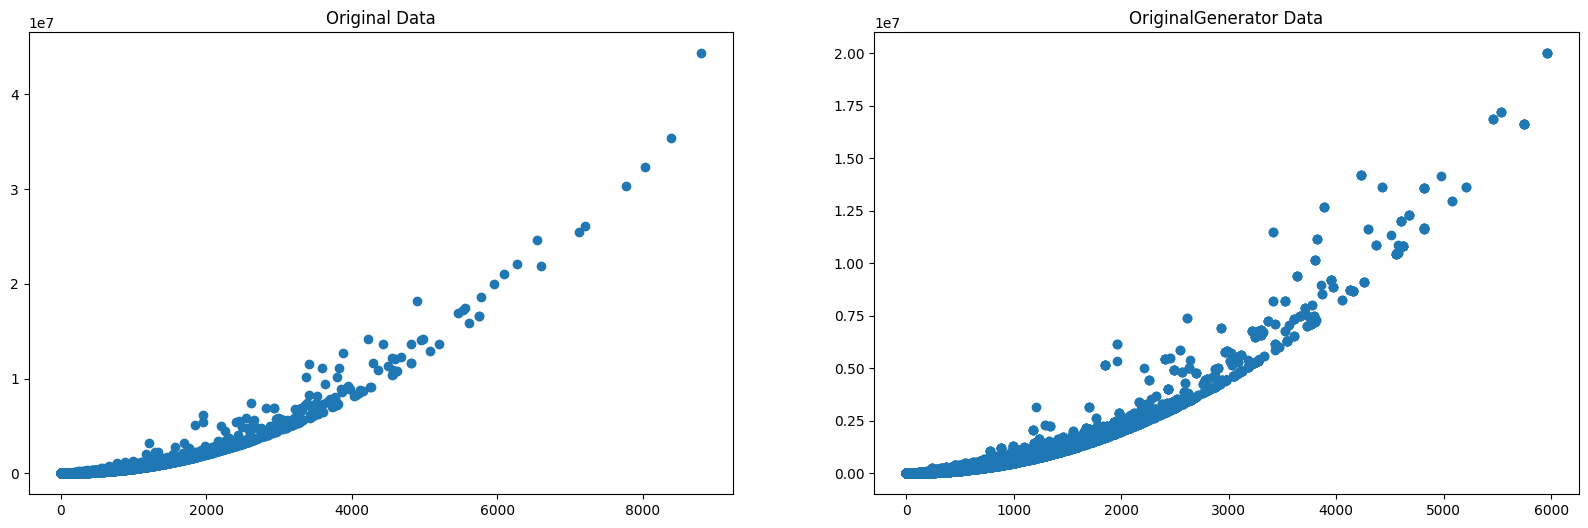

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(X_train.iloc[:, 42], X_train.iloc[:, 43])
ax[1].scatter(new_train1.iloc[:, 42], new_train1.iloc[:, 43])
ax[0].set_title("Original Data")
ax[1].set_title("OriginalGenerator Data")

Text(0.5, 1.0, 'OriginalGenerator Data')

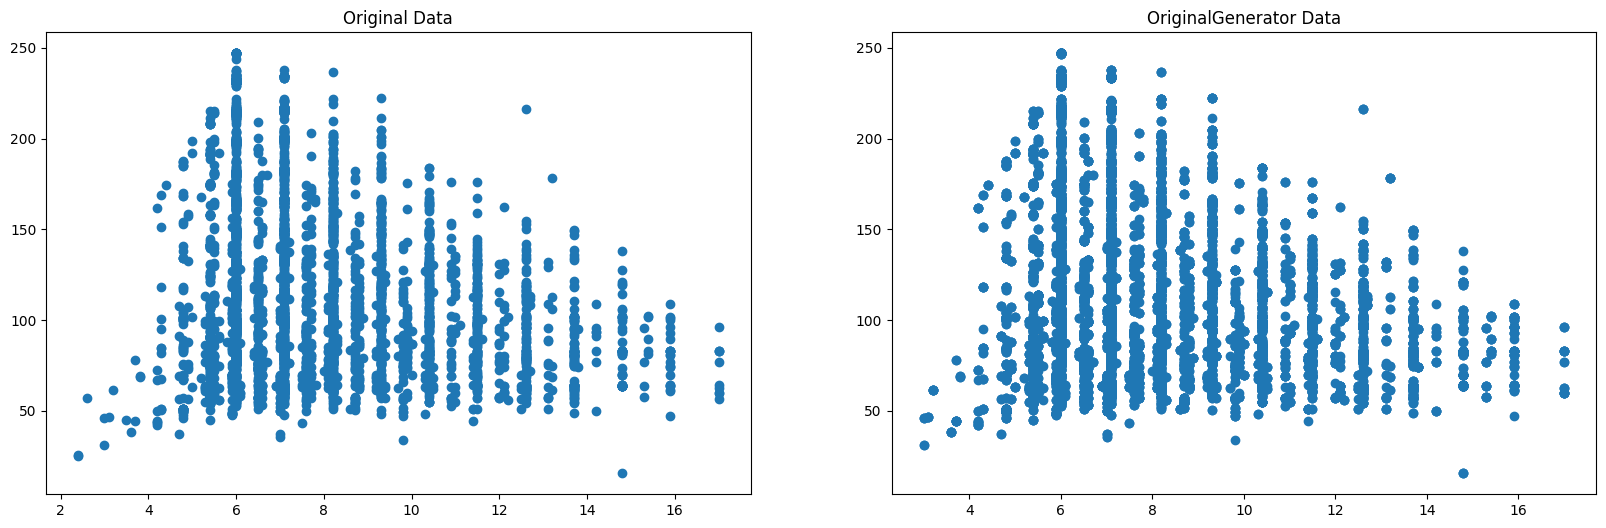

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(X_train.iloc[:, 2], X_train.iloc[:, 3])
ax[1].scatter(new_train1.iloc[:, 2], new_train1.iloc[:, 3])
ax[0].set_title("Original Data")
ax[1].set_title("OriginalGenerator Data")

Text(0.5, 1.0, 'CTGANGenerator Data')

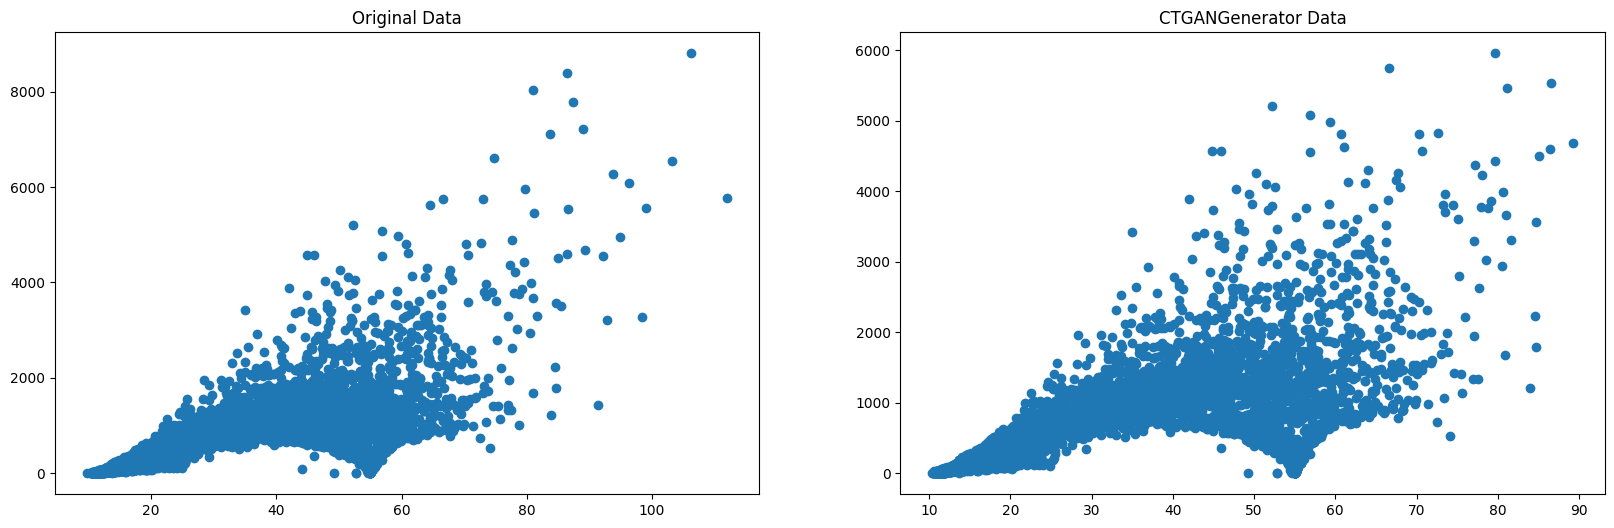

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(X_train.iloc[:, 41], X_train.iloc[:, 42])
ax[1].scatter(new_train2.iloc[:, 41], new_train2.iloc[:, 42])
ax[0].set_title("Original Data")
ax[1].set_title("CTGANGenerator Data")

Text(0.5, 1.0, 'CTGANGenerator Data')

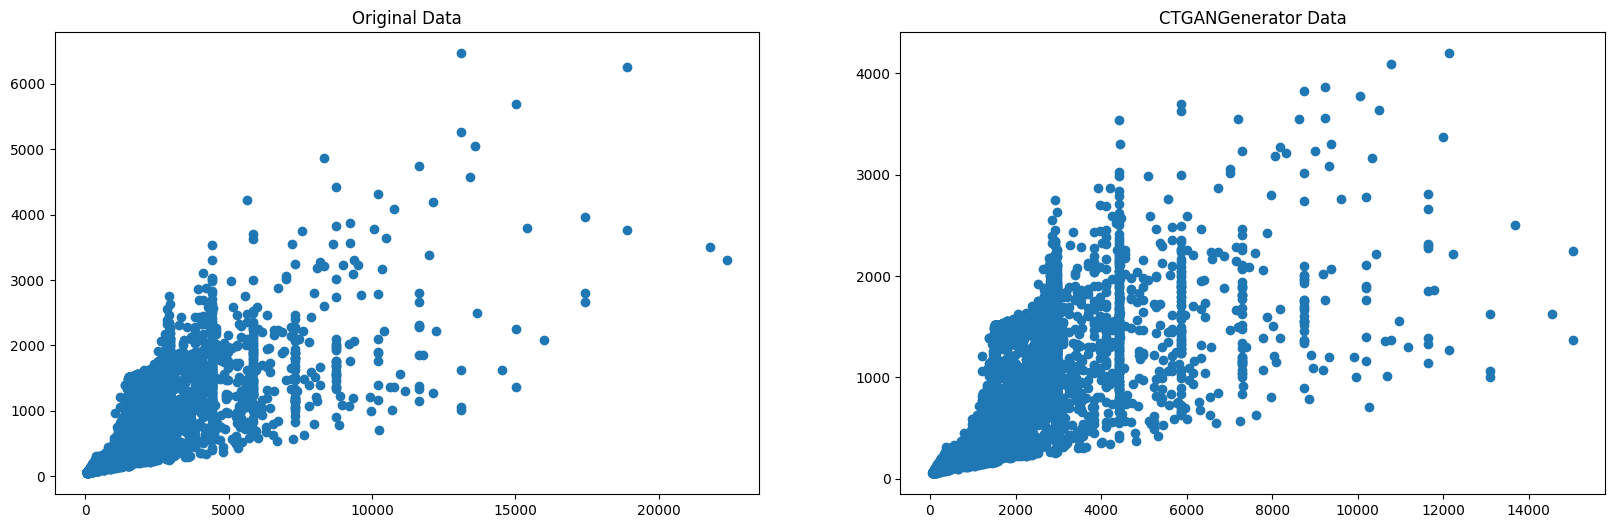

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(X_train.iloc[:, 35], X_train.iloc[:, 36])
ax[1].scatter(new_train2.iloc[:, 35], new_train2.iloc[:, 36])
ax[0].set_title("Original Data")
ax[1].set_title("CTGANGenerator Data")

# Check the distribution of generated data

In [47]:
flipped_dict = dict((v, k) for k, v in class_mapping.items())

In [48]:
new_target1 = pd.DataFrame(new_target1)
new_target2 = pd.DataFrame(new_target2)

In [49]:
new_target1['label'] = new_target1['label'].replace(flipped_dict)
new_target2['label'] = new_target2['label'].replace(flipped_dict)

In [50]:
new_target1['label'].value_counts()

label
BenignTraffic           15149
SqlInjection              746
Recon                     580
DNS_Spoofing              373
DictionaryBruteForce       55
Uploading_Attack           40
BrowserHijacking           23
CommandInjection           13
Backdoor_Malware           12
XSS                         4
MITM-ArpSpoofing            1
Name: count, dtype: int64

In [51]:
new_target2['label'].value_counts()

label
BenignTraffic           5021
SqlInjection             268
Recon                    195
DNS_Spoofing             132
DictionaryBruteForce      19
Uploading_Attack          13
BrowserHijacking           7
CommandInjection           5
Backdoor_Malware           4
XSS                        2
MITM-ArpSpoofing           1
Name: count, dtype: int64